# JHU covid-19 daily data processing 

Test and update functions for JHU data analysis

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import glob
import os
 
import matplotlib.ticker as mticker
import matplotlib.dates as mdates 

from datetime import timedelta 
import datetime
import pytz
from tzwhere import tzwhere  


from matplotlib.dates import date2num       #-->Update

import matplotlib
from matplotlib import cm


import os
import sys
base_path = os.path.dirname( os.getcwd()  )   
sys.path.append(base_path ) 
import JHU_dataprocessing_functions as dp
import JHU_plotting_functions as jp 

# general parameters 

In [93]:
full_w = (12,7)
half_w = (6,4)

# Load daily reports 

In [94]:
path = r'D:\Code_projects\Covid19_analysis\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports'

daily_reports = glob.glob(path + '\*.csv') 
df = pd.DataFrame()
for file in daily_reports :
    df_temp = pd.read_csv( file, index_col=None, header=0) 
    df = df.append(df_temp, sort=True) 

df.tail()

,Active,Admin2,Combined_Key,Confirmed,Country/Region,Country_Region,Deaths,FIPS,Last Update,Last_Update,Lat,Latitude,Long_,Longitude,Province/State,Province_State,Recovered
3137,98.0,NaN,"Queensland, Australia",1030.0,NaN,Australia,6.0,NaN,NaN,2020-04-27 02:31:20,-27.4698,NaN,153.0251,NaN,NaN,Queensland,926.0
3138,23.0,NaN,"South Australia, Australia",438.0,NaN,Australia,4.0,NaN,NaN,2020-04-27 02:31:20,-34.9285,NaN,138.6007,NaN,NaN,South Australia,411.0
3139,78.0,NaN,"Tasmania, Australia",212.0,NaN,Australia,11.0,NaN,NaN,2020-04-27 02:31:20,-42.8821,NaN,147.3272,NaN,NaN,Tasmania,123.0
3140,67.0,NaN,"Victoria, Australia",1349.0,NaN,Australia,17.0,NaN,NaN,2020-04-27 02:31:20,-37.8136,NaN,144.9631,NaN,NaN,Victoria,1265.0
3141,55.0,NaN,"Western Australia, Australia",549.0,NaN,Australia,8.0,NaN,NaN,2020-04-27 02:31:20,-31.9505,NaN,115.8605,NaN,NaN,Western Australia,486.0


# adjust column names and use only relevant columns

In [95]:
# convert different datetimes to same datetime column 
df['Last Update'] = pd.to_datetime(df['Last Update']   )
df['Last_Update'] = pd.to_datetime(df['Last_Update']   )   #  
cond = df['Last_Update'].isnull()
df['Last Update'] = df['Last Update'].where(cond, df['Last_Update'] ) 
df['Datetime']= pd.to_datetime(df['Last Update'] , unit='D'   ) 
df['Date'] = df['Datetime'].dt.date

cond = df['Country_Region'].isnull()
df['Country/Region'] = df['Country/Region'].where(cond, df['Country_Region'] ) 

cond = df['Province_State'].isnull()
df['Province/State'] = df['Province/State'].where(cond, df['Province_State'] ) 
 
col_order = ['Date','Country/Region','Province/State','Active','Confirmed','Deaths','Recovered','Combined_Key' ]
df = df[col_order]

df.tail()

,Date,Country/Region,Province/State,Active,Confirmed,Deaths,Recovered,Combined_Key
3137,2020-04-27,Australia,Queensland,98.0,1030.0,6.0,926.0,"Queensland, Australia"
3138,2020-04-27,Australia,South Australia,23.0,438.0,4.0,411.0,"South Australia, Australia"
3139,2020-04-27,Australia,Tasmania,78.0,212.0,11.0,123.0,"Tasmania, Australia"
3140,2020-04-27,Australia,Victoria,67.0,1349.0,17.0,1265.0,"Victoria, Australia"
3141,2020-04-27,Australia,Western Australia,55.0,549.0,8.0,486.0,"Western Australia, Australia"


# process columns 

In [96]:
bool_US = df['Country/Region'] =='US' 
# bool_last = df['Date'] > datetime.datetime(2020,3,22).date() 
bool_last = df['Date'] > datetime.datetime(2020,3,23).date()
 
df_US = df[bool_US & bool_last ].copy() 
 
df_US =  df_US.groupby(['Province/State','Date']).sum().reset_index()  
df_US = df_US.sort_values( by=['Province/State','Date']).reset_index(drop=True)  
 
df_US.head()
 

,Province/State,Date,Active,Confirmed,Deaths,Recovered
0,Alabama,2020-03-24,0.0,242.0,0.0,0.0
1,Alabama,2020-03-25,0.0,381.0,1.0,0.0
2,Alabama,2020-03-26,0.0,517.0,1.0,0.0
3,Alabama,2020-03-27,0.0,587.0,4.0,0.0
4,Alabama,2020-03-28,0.0,694.0,4.0,0.0


# transform state geometry 

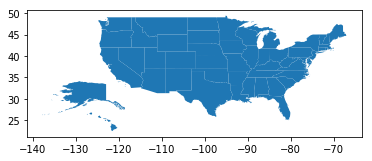

In [97]:
import geopandas as gpd

    
data_path = os.path.join(  base_path,  'geo_data\states.shp' )  
US = gpd.read_file(data_path)
AKratio = 0.4;  # scales Alaska 
HIratio = 1.3 # scales Hawai 
AKtrans = [25,-33] # moves Alaska south and east 
HItrans = [34,4] # moves Hawaii east and north 
 
import shapely.affinity as shp

# get original polygons
bool_alaska = US['STATE_NAME'] == 'Alaska'
alaska_object = US.loc[bool_alaska,'geometry']
alaska_geom = US.loc[bool_alaska,'geometry'].iloc[0] 

alaska_moved = shp.translate(alaska_geom, AKtrans[0], AKtrans[1])  
centroid = alaska_moved.centroid
alaska_scaled = shp.scale( alaska_moved, xfact=AKratio, yfact=AKratio, origin=centroid)
# US['geometry'][50] =  alaska_scaled
alaska_object.iloc[0] = alaska_scaled
US.loc[bool_alaska,'geometry'] = alaska_object

# # US['geometry'][50] =  alaska_scaled

bool_hawaii = US['STATE_NAME'] == 'Hawaii'
hawaii_obj = US.loc[bool_hawaii,'geometry']
hawaii_geom = hawaii_obj.iloc[0]

hawaii_moved = shp.translate(hawaii_geom, HItrans[0], HItrans[1])  
centroid = hawaii_moved.centroid
hawaii_scaled = shp.scale( hawaii_moved, xfact=HIratio, yfact=HIratio, origin=centroid)
hawaii_obj.iloc[0] = hawaii_scaled

US.loc[bool_hawaii,'geometry'] =  hawaii_obj

  
 
US.plot()
 

In [98]:
# type( US.loc[bool_alaska,'geometry']  )
alaska_obj = US.loc[bool_alaska,'geometry']

geom = alaska_obj.iloc[0]

alaska_obj.iloc[0] = geom
alaska_obj 
# US['geometry'] 

50    (POLYGON ((-131.076298949224 29.08360244818114...
Name: geometry, dtype: object

In [99]:
df_US

,Province/State,Date,Active,Confirmed,Deaths,Recovered
0,Alabama,2020-03-24,0.0,242.0,0.0,0.0
1,Alabama,2020-03-25,0.0,381.0,1.0,0.0
2,Alabama,2020-03-26,0.0,517.0,1.0,0.0
3,Alabama,2020-03-27,0.0,587.0,4.0,0.0
4,Alabama,2020-03-28,0.0,694.0,4.0,0.0
5,Alabama,2020-03-29,0.0,825.0,10.0,0.0
6,Alabama,2020-03-30,0.0,899.0,10.0,0.0
7,Alabama,2020-03-31,0.0,987.0,23.0,0.0
8,Alabama,2020-04-01,0.0,1060.0,27.0,0.0
9,Alabama,2020-04-02,0.0,1233.0,32.0,0.0


In [103]:
 

dates = df_US['Date'].sort_values().unique()

dates
bool_date = df_US['Date'] == dates[-1]
bool_prior = df_US['Date'] == dates[-7] 


states = df_US.loc[bool_prior,'Province/State'].unique().tolist()



for state in states: 
#     print(state)
    bool_state = df_US['Province/State'] == state 
    bool_date = df_US['Date'] == dates[-1]
    bool_prior = df_US['Date'] == dates[-7] 

    if (bool_state & bool_date).sum() > 0:
        now_cases = df_US[bool_state & bool_date ]['Confirmed'].iloc[0]
        prior_cases = df_US[bool_state & bool_prior ]['Confirmed'].iloc[0]
        
        
        print(now_cases,prior_cases)
        latest_cases = (now_cases-prior_cases)/7
    else:
        latest_cases = 0 
         
    df_US.loc[bool_state ,'Cases'] = np.log(latest_cases + 2)
    
    
US['Cases'] = 0 
df_US = df_US.rename(columns={'Province/State':'STATE_NAME'}) 

df_US = df_US[bool_date] 
US= pd.merge(US, df_US, how='left', on=['STATE_NAME'])
df_US.head()  



6421.0 5317.0
340.0 329.0
6534.0 5256.0
3001.0 1990.0
43558.0 35465.0
13441.0 10473.0
25269.0 20360.0
4034.0 2931.0
49.0 49.0
3841.0 3098.0
31532.0 27869.0
23486.0 19881.0
103.0 103.0
141.0 136.0
606.0 586.0
1897.0 1736.0
43903.0 33059.0
15012.0 12097.0
5476.0 3641.0
3277.0 2164.0
4085.0 3204.0
26773.0 24854.0
1015.0 888.0
18581.0 14193.0
54938.0 41199.0
37778.0 32667.0
3602.0 2567.0
5911.0 4716.0
7120.0 6066.0
448.0 437.0
3028.0 1685.0
4734.0 3937.0
1864.0 1490.0
109038.0 92387.0
2726.0 1971.0
158258.0 258361.0
8997.0 7134.0
867.0 644.0
14.0 14.0
15972.0 13725.0
3254.0 2807.0
2311.0 2004.0
42616.0 35249.0
1371.0 1298.0
0.0 0.0
7439.0 5500.0
5498.0 4439.0
2212.0 1755.0
9667.0 7394.0
24967.0 20574.0
4123.0 3297.0
851.0 818.0
57.0 53.0
12970.0 9630.0
1055.0 908.0
5912.0 4625.0
502.0 443.0


D:\D_program_files\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log


,STATE_NAME,Date,Active,Confirmed,Deaths,Recovered,Cases
33,Alabama,2020-04-27,6202.0,6421.0,219.0,0.0,5.073387
67,Alaska,2020-04-27,331.0,340.0,9.0,0.0,1.272966
108,Arizona,2020-04-27,6259.0,6534.0,275.0,0.0,5.218037
142,Arkansas,2020-04-27,2950.0,3001.0,51.0,0.0,4.986538
176,California,2020-04-27,41833.0,43558.0,1725.0,0.0,7.054573


# plot US map

KeyError: 'Cases'

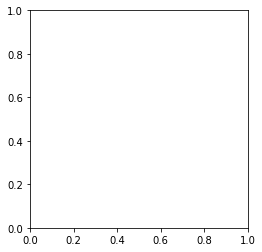

In [104]:
# fig, ax = plt.subplots(1,1 ,figsize=(15,8))
fig, ax = plt.subplots(1,1 ,figsize=half_w )


wp = US.plot(column='Cases', ax=ax, cmap='OrRd'   );

wp.set_xbound(-135,-66)
wp.set_ybound(20,49.5)  
 

vmin =    US['Cases'].min()
vmax =  ( US['Cases'].max() )
 
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax)) 
 



# fake up the array of the scalar mappable. Urgh...
sm._A = []
cax = fig.add_axes([0.2, 0.25, 0.6, 0.03])
cb = fig.colorbar(sm, cax=cax, orientation='horizontal')
 

# tick_array =  [1,10,100,1000,10000,10000] 
tick_array =  [20,40,100,400,1000,4000,10000 ] 
log_cases = np.log( tick_array  )  
cb.set_ticks( log_cases ) 
cb.set_ticklabels( tick_array) 
cb.set_label(' Daily case increaes  \n (average over last 7 days)')

ax.axis("off")


ax.annotate('Updated '+str( df_US['Date'].iloc[-1]), 
            [-135,22 ], color=[.3,.3,.3], style='italic',fontsize=8)
 

In [ ]:
df_US